# Кейс №1 - Приложение знакомств

Импортируем все необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

Загрузим данные и файла csv в датафрейм df:

In [2]:
df=pd.read_csv('dating_data.csv')

Посмотрим на данные, их типы, наличие пустых значений:

In [3]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.shape

(14514, 4)

In [5]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [6]:
df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

## 1. В качестве первой метрики выбираем долю мэтчей в двух группах

Сначала посмотрим на графике, как распределяются мэтчи и не мэтчи в двух группах:

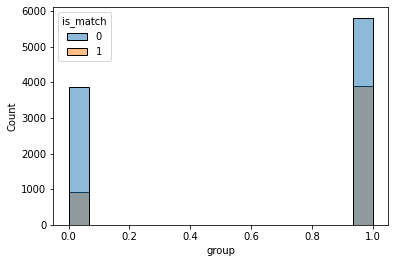

In [8]:
sns.histplot(df, x = "group", hue = "is_match")

Визуально видно, что в первой группе доля мэтчей больше. Проверим, является ли различие в группах статистически значимым. У нас 2 категориальные переменные, поэтому будем использовать критерий ХИ квадрат. 
𝐻0
 : взаимосвязи между переменными нет
𝐻1
 : взаимосвязь есть

In [8]:
from scipy.stats import chi2_contingency, chi2 

In [9]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.is_match, df.group))

In [10]:
stat, p

(618.6889141576197, 1.441829916366341e-136)

p-value<0.05, следовательно отклоняем Н0. Проверим долю мэтчей в группах 0 и 1:

In [19]:
match0=((df.query('group==0').is_match.sum())/df.query('group==0').shape[0])*100
print("Доля мэтчей в группе 0 =", match0, "%")
match1=((df.query('group==1').is_match.sum())/df.query('group==1').shape[0])*100
print("Доля мэтчей в группе 1 =", match1, "%")

Доля мэтчей в группе 0 = 19.490818030050082 %
Доля мэтчей в группе 1 = 40.20777617774121 %


## 1. Заключение по первой метрике. Мы сравниваем две категориальные переменные, поэтому для проверки гипотезы я использую критерий Хи-квадрат. Результат оказался статистически ЗНАЧИМ. Значит, ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ. У пользователей из группы 1, использующих новый алгоритм, мэтчей больше. 

## 2. В качестве второй метрики выбираю количество взаимодействий (активностей) каждого пользователя

Для проверки этой метрики необходимо посчитать, сколько взаимодействий (попыток составить мэтч) приходится на каждого пользователя. Пользователь может оказаться, как в столбце user_id1, так и в столбце user_id2, поэтому эти столбцы необходимо объединить и положить в новый датафрейм users_total:

In [23]:
user_id_1=df[['user_id_1','group', 'is_match']]
user_id_2=df[['user_id_2','group', 'is_match']]
user_id_1=user_id_1.rename(columns={'user_id_1':'user_id'})
user_id_2=user_id_2.rename(columns={'user_id_2':'user_id'})
users_total=pd.concat([user_id_1,user_id_2])
users_total=users_total.groupby(['user_id','group'], as_index=False).agg({'is_match':'count'}).sort_values('is_match')
users_total=users_total.rename(columns={'is_match':'actions_number'})
users_total.head()

,user_id,group,actions_number
435,436,0,8
882,883,0,8
21,22,0,9
660,661,0,10
942,943,0,10


Сначала посмотрим на графике, как распределяются количество взаимодействий в двух группах:

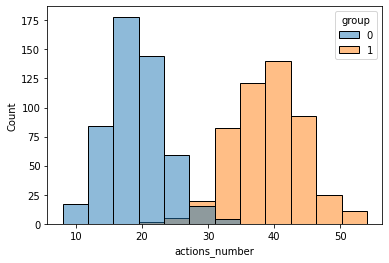

In [24]:
sns.histplot(users_total, x="actions_number", hue="group")

In [ ]:
По графику видно, что среднее кол-во взаимодействий в первой группе больше, чем в нулевой. Посчитаем средние значения

In [27]:
mean_actions_0=users_total.query('group==0').actions_number.mean()
print("Среднее количество взаимодействий в группе 0 =", mean_actions_0)
mean_actions_1=users_total.query('group==1').actions_number.mean()
print("Среднее количество взаимодействий в группе 1 =", mean_actions_1)

Среднее количество взаимодействий в группе 0 = 19.129740518962077
Среднее количество взаимодействий в группе 1 = 38.965931863727455


Проверим, является ли различие в группах статистически значимым. Для начала проверим нормальность распределений:

In [30]:
group_0=users_total.query('group==0').actions_number
group_1=users_total.query('group==1').actions_number
print(ss.normaltest(group_0))
print(ss.normaltest(group_1))

NormaltestResult(statistic=5.2143995596467665, pvalue=0.07374074524621803)
NormaltestResult(statistic=0.31965834724445935, pvalue=0.8522893700372094)


p-value для обоих групп >0.05, значит мы принимаем гипотезу Н0 - распределения являются нормальными. Распределения являются нормальными, значит можем использовать T-test:

In [31]:
ss.ttest_ind(group_0, group_1)

Ttest_indResult(statistic=-62.837086115525075, pvalue=0.0)

P-value<0.05, значит мы отклоняем нулевую гипотезу и различия являются статистически значимыми.

## 2. Заключение по второй метрике: Распределение переменной actions_number (количество взаимодействий)является нормальным, поэтому для проверки гипотезы я использую T-test. Результат оказался статистически значим. Значит, значимые различия есть, пользователи в группе 1, использующие новый алгоритм, стали более активны.

# Вывод: новый алгоритм успешно прошел проверку по двум метрикам: пользователи стали более активны и количество мэтчей увеличилось при его использовании. Новую систему поиска анкет стоит  включить  на всех пользователей.